In [1]:
import os
import json

from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(0)

from torch.optim import Adam
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from livelossplot import PlotLosses

import ternausnet.models
# model = ternausnet.models.UNet11(pretrained=True)

In [125]:
root_path = 'datasets/landcover_processed/rotated_crops/'
list_dataset = list(filter(lambda x: x.endswith('.png'), os.listdir(root_path)))
list_dataset = list(map(lambda x: root_path + x, list_dataset))
list_dataset = list_dataset[:7000]
#train_img_list, test_img_list = train_test_split(list_dataset, test_size=0.15)
#test_img_list = list(filter(lambda x: x.endswith('-0.png'), test_img_list))

In [126]:
def root(name):
    return "-".join(name.split("/")[-1].split(".")[-2].split("-")[:-2 or None])

In [127]:
list_root = [root(name) for name in list_dataset]
list_root = list(set(list_root))
len(list_root)

37

In [128]:
train_root_list, test_root_list = train_test_split(list_root, test_size=0.15)

In [129]:
len(train_root_list), len(test_root_list)

(31, 6)

In [130]:
train_img_list = []
test_img_list = []
for name in list_dataset:
    if root(name) in test_root_list and not name.endswith('-0.png'):
        test_img_list.append(name)
    else:
        train_img_list.append(name)

In [131]:
len(train_img_list), len(test_img_list)

(6436, 564)

In [88]:
print(len(train_img_list), len(test_img_list))
with open('train_img_list.json', 'w') as f:
    json.dump(train_img_list, f)
    
with open('test_img_list.json', 'w') as f:
    json.dump(test_img_list, f)

942 58


In [89]:
from lib.train import WaterDataset, viz, train_transform, test_transform

In [90]:
d_train = WaterDataset('train_img_list.json', train_transform)
d_val = WaterDataset('test_img_list.json', test_transform)

In [91]:
len(d_train)

942

In [92]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [93]:
def viz2(s):
    img = (s * torch.tensor([0.229, 0.224, 0.225])[:, None, None] + torch.tensor([0.485, 0.456, 0.406])[:, None,None])
    print(img.min(), img.max(), img.shape)
    img = (255 * (img.transpose(0,1).transpose(1,2).numpy())).astype(np.uint8)
    print(img.shape)
    plt.imshow(img)
    return img

In [94]:
d_val[10][1].shape

torch.Size([1, 224, 224])

In [ ]:
II = viz2(d_val[10][0])

In [ ]:
II.shape

In [ ]:
import json
with open('test_img_list.json', 'r') as f:
    path = json.load(f)[10]

In [ ]:
import cv2
I = cv2.imread('datasets/landcover_processed/rotated_crops/N-34-66-C-c-4-3-773-60.png', cv2.IMREAD_UNCHANGED)

In [ ]:
from PIL import Image
I = Image.open('datasets/landcover_processed/rotated_crops/N-34-66-C-c-4-3-773-60.png',).resize((224,224))

In [ ]:
#plt.hist((II.astype(np.int32)-I[:,:,[2,1,0]].astype(np.int32)).reshape(-1))

In [ ]:
#plt.imshow(II-I[:,:,[2,1,0]])

In [ ]:
I.mode

In [ ]:
#I = cv2.resize(I, (224,224), interpolation=cv2.INTER_LINEAR)

In [ ]:
#I.shape

In [ ]:
#I[:,:,[-1]].shape

In [ ]:
#plt.imshow(I[:, :, [2,1,0]])

In [14]:
d_val[3]

(tensor([[[-0.2171, -0.4397, -0.2171,  ...,  0.2282,  0.3138,  0.4337],
          [-0.3198, -0.4226, -0.6623,  ...,  0.2282,  0.3823,  0.4337],
          [-0.1486, -0.2684, -0.5082,  ...,  0.4337,  0.3994,  0.5536],
          ...,
          [-0.2342, -0.3541, -0.0801,  ..., -0.8335, -0.8678, -0.5253],
          [-0.2513, -0.3712, -0.3712,  ..., -0.7308, -0.9534, -0.5082],
          [-0.2684, -0.3712, -0.3712,  ..., -0.7822, -0.9192, -0.4054]],
 
         [[-0.2675, -0.4076, -0.1099,  ...,  0.2402,  0.3277,  0.3978],
          [-0.4251, -0.4426, -0.5826,  ...,  0.2577,  0.3627,  0.3803],
          [-0.3025, -0.3025, -0.4426,  ...,  0.4153,  0.3277,  0.4503],
          ...,
          [-0.1800, -0.2850,  0.0126,  ..., -0.5826, -0.6527, -0.2850],
          [-0.1975, -0.3375, -0.3375,  ..., -0.4776, -0.7577, -0.2675],
          [-0.2150, -0.3375, -0.3375,  ..., -0.5476, -0.7227, -0.1625]],
 
         [[-0.2532, -0.3927, -0.0964,  ..., -0.0267,  0.0431,  0.1128],
          [-0.3578, -0.3753,

In [115]:
class Metric:
    def __init__(self):
        self.val = 0
        self.N = 0
        self.hist = []

        
    def calc(self, *args):
        raise NotImplementedError
    
    def append(self, *args):
        self.val += self.calc(*args)
        self.N += 1
        
    def result(self):
        return self.val / self.N
    
    def reset(self):
        self.val = 0
        self.N = 0
        
    def history(self):
        self.hist.append(self.val)
    
    
class AccuracyMetric(Metric):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold
        
    def calc(self, pred, gt):
        return ((pred > self.threshold) == gt.bool()).sum().item() / pred.numel()

# true positive
class LakeAccuracyMetric(Metric):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold
        
    def calc(self, pred, gt):
        return ((gt == 1) & (pred > self.threshold)).sum().item() / (gt == 1).sum().item()

# false negative    
class NoLakeAccuracyMetric(Metric):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold
        
    def calc(self, pred, gt):
        return ((gt == 0) & (pred < self.threshold)).sum().item() / (gt == 0).sum().item()

    
class LossMetric(Metric):
    def __init__(self):
        super().__init__()
        #self.threshold = threshold
        
    def calc(self, loss):
        return loss.item()


In [116]:
acc = AccuracyMetric(0.5)

pred = torch.tensor([0.6,0.4,0.1])
gt = torch.tensor([1,0,1])

acc.append(pred, gt)

pred = torch.tensor([0.6,0.4,0.1])
gt = torch.tensor([1,0,0])


acc.append(pred, gt)

acc.result()

0.8333333333333333

In [117]:

def trainer(cfg, train_id=None, num_workers=20, device=None):
    
    device = device or 'cuda:0' ##
    train_id = train_id or cfg['train_id']
    use_pretrained_vgg=cfg["use_pretrained_vgg"]
    batch_size=cfg["batch_size"]
    lr=cfg["lr"]
    num_epochs=cfg["num_epochs"]   
    
    # ?? self.train_img_list = ["train_img_list"]
    # ?? self.test_img_list = cfg["test_img_list"]
   
    model = ternausnet.models.UNet11(pretrained=use_pretrained_vgg)
    
    if cfg['pretrained_model'] is not None:
        model.load_state_dict(torch.load(cfg['pretrained_model']))
    model = model.to(device)

    loss = nn.BCEWithLogitsLoss()
   
    optimizer = Adam(model.parameters(), lr)    
    
    dl_train = DataLoader(d_train, batch_size, shuffle=True, num_workers=num_workers)
    dl_val = DataLoader(d_val, batch_size, shuffle=False, num_workers=num_workers)

        
    metrics = {
        'val_acc': AccuracyMetric(0.5),
        'train_acc': AccuracyMetric(0.5),
        'val_loss': LossMetric(),
        'train_loss': LossMetric(),
        'train_lake_acc': LakeAccuracyMetric(0.5),
        'val_lake_acc': LakeAccuracyMetric(0.5),
        'train_nolake_acc': NoLakeAccuracyMetric(0.5),
        'val_nolake_acc': NoLakeAccuracyMetric(0.5),
    }
    
    groups = {
        'accuracy': ['train_acc', 'val_acc'], 
        'bce-loss': ['train_loss', 'val_loss'], 
        'lake-acc': ['train_lake_acc', 'val_lake_acc'],
        'nolake_acc': ['train_nolake_acc', 'val_nolake_acc'],
    }
    plotlosses = PlotLosses(groups=groups)

    topk_val_losses = {}

    for epoch in range(num_epochs):
        print('train step')
        for name, metric in metrics.items():
            metric.reset()

        for idx, (im, gt) in enumerate(dl_train):
            im = im.to(device)
            gt = gt.to(device)
            optimizer.zero_grad()

            pred = model(im)
            L = loss(pred, gt)
            L.backward()
            assert pred.shape == gt.shape
            metrics['train_acc'].append(pred, gt)
            metrics['train_lake_acc'].append(pred, gt)
            metrics['train_nolake_acc'].append(pred, gt)
            metrics['train_loss'].append(L)
            optimizer.step()

            #if (idx % 10) == 0:
            #    pass # eval

            
        print('eval step')
        for idx, (im, gt) in enumerate(dl_val):
            im = im.to(device)
            gt = gt.to(device)
            pred = model(im)
            L = loss(pred, gt)
            metrics['val_acc'].append(pred, gt)
            metrics['val_lake_acc'].append(pred, gt)
            metrics['val_nolake_acc'].append(pred, gt)
            metrics['val_loss'].append(L)


        results = {key: metrics[key].result() for key in metrics}
        plotlosses.update(results)
        plotlosses.send()

        for name, metric in metrics.items():
            metric.history()

        
#         if (len(topk_val_losses) < 5) or (val_loss < max(topk_val_losses.keys())):
#             if (len(topk_val_losses) > 0) and (val_loss < max(topk_val_losses.keys())):
#                 argmin = max(topk_val_losses.keys())
#                 fname = topk_val_losses[argmin]
#                 os.remove(fname)
#                 del topk_val_losses[argmin]
#             topk_val_losses[val_loss] = f'model-{train_id}-{epoch}.pth'
#             torch.save(model.state_dict(), f'model-{train_id}-{epoch}.pth')

    torch.save(model.state_dict(), 'model-latest.pth')

In [118]:
with open('train_config.json', 'r') as f:
    cfg = json.load(f)

In [119]:
# groups = {'acccuracy': ['acc', 'val_acc'], 'bce-loss': ['loss', 'val_loss'], 'lake-acc': ['lakeacc', 'val_lakeacc']}
# plotlosses = PlotLosses(groups=groups)

# groups = {'acccuracy': ['train_acc', 'val_acc']}
# plotlosses = PlotLosses(groups=groups)

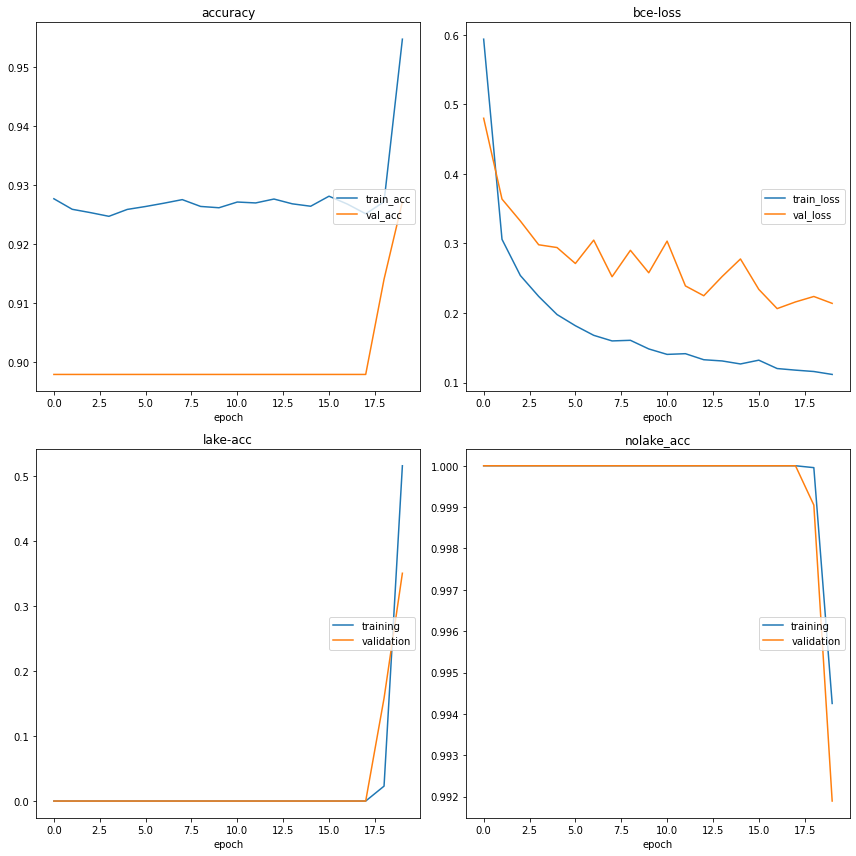

accuracy
	train_acc        	 (min:    0.925, max:    0.955, cur:    0.955)
	val_acc          	 (min:    0.898, max:    0.927, cur:    0.927)
bce-loss
	train_loss       	 (min:    0.112, max:    0.594, cur:    0.112)
	val_loss         	 (min:    0.206, max:    0.480, cur:    0.214)
lake-acc
	training         	 (min:    0.000, max:    0.516, cur:    0.516)
	validation       	 (min:    0.000, max:    0.350, cur:    0.350)
nolake_acc
	training         	 (min:    0.994, max:    1.000, cur:    0.994)
	validation       	 (min:    0.992, max:    1.000, cur:    0.992)


In [120]:
trainer(cfg['from_scratch'], train_id="scratch")

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print(torch.cuda.is_available())